# 深度学习第三课：两层 MLP 与反向传播（手写版）

## 这节课的唯一教学目标

让你亲眼看到：

> **「线性模型做不到的事，通过一层非线性 + 再线性，就能做到。」**

这不是关于性能，不是关于工程，而是一次**认知跃迁**。

---

## 前置知识

本课假设你已经学过：
- **第一课**（线性回归）：梯度下降、前向传播、反向传播的基本概念
- **第二课**（逻辑回归）：Sigmoid 函数、Binary Cross Entropy 损失函数、二分类问题

如果你对 Sigmoid 或 BCE 还不熟悉，请先回顾第二课的内容。

---

## 为什么选择 XOR 数据集？

XOR 是深度学习历史上最经典的教学数据集：

| 特点 | 原因 |
|------|------|
| 单层线性模型**数学上不可能**拟合 | 这是被证明过的 |
| 两层 MLP **立刻可以** | 最小的"打脸"结构 |
| 2D 数据 → 可画图 | 能直观看到 decision boundary |
| 样本极少（4个点） | 没有任何噪声干扰理解 |

这是你第一次**亲眼看到神经网络不是线性模型**的时刻。

---
## 1. 环境准备

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

---
## 2. XOR 数据集

XOR（异或）的真值表：

| $x_1$ | $x_2$ | $y$ |
|-------|-------|-----|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

规律：**只有当两个输入不同时，输出才为 1**。

In [2]:
# 四个原始点
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
y = np.array([[0], [1], [1], [0]])  # XOR

print("输入 X:")
print(X)
print("\n输出 y:")
print(y.flatten())

输入 X:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

输出 y:
[0 1 1 0]


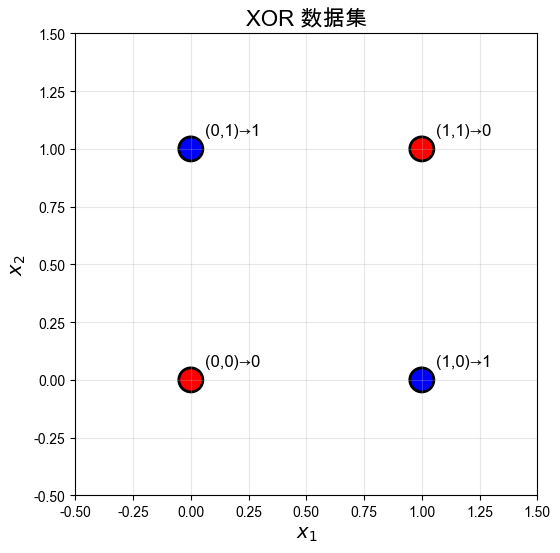


观察：红色点(0)在对角线上，蓝色点(1)在另一条对角线上
问题：你能画一条直线把红色和蓝色分开吗？


In [3]:
# 可视化 XOR 数据
plt.figure(figsize=(6, 6))
colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
plt.scatter(X[:, 0], X[:, 1], c=colors, s=300, edgecolors='black', linewidth=2)

for i, (x1, x2) in enumerate(X):
    plt.annotate(f'({x1},{x2})→{y[i,0]}', (x1, x2), 
                 xytext=(10, 10), textcoords='offset points', fontsize=12)

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('XOR 数据集', fontsize=16)
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal')
plt.show()

print("\n观察：红色点(0)在对角线上，蓝色点(1)在另一条对角线上")
print("问题：你能画一条直线把红色和蓝色分开吗？")

---
## 3. Step 1：先用线性模型失败（非常重要！）

我们先用最简单的线性模型（逻辑回归）上节课的内容，来尝试分类 XOR。

### 线性模型结构

$$\hat{y} = \sigma(w_1 x_1 + w_2 x_2 + b)$$

其中 $\sigma$ 是 sigmoid 函数：$\sigma(z) = \frac{1}{1 + e^{-z}}$

In [4]:
# 复用第二课的函数（Sigmoid 和 BCE 在第二课已详细讲解）
def sigmoid(z):
    """Sigmoid 激活函数（详见第二课）"""
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y, y_hat):
    """二元交叉熵损失（详见第二课）"""
    epsilon = 1e-8
    return -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))

In [5]:
# 训练线性模型
np.random.seed(42)
w_linear = np.random.randn(2, 1) * 0.5
b_linear = np.zeros((1, 1))

learning_rate = 1.0
losses_linear = []

print("训练线性模型...")
print("-" * 50)

for epoch in range(1000):
    # 前向传播
    z = X @ w_linear + b_linear
    y_hat = sigmoid(z)
    
    # 计算损失
    loss = binary_cross_entropy(y, y_hat)
    losses_linear.append(loss)
    
    # 反向传播
    dz = y_hat - y
    dw = X.T @ dz / len(X)
    db = np.mean(dz)
    
    # 更新参数
    w_linear = w_linear - learning_rate * dw
    b_linear = b_linear - learning_rate * db
    
    if epoch % 200 == 0:
        predictions = (y_hat > 0.5).astype(int)
        accuracy = np.mean(predictions == y)
        print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Accuracy: {accuracy:.0%}")

print("-" * 50)
print(f"最终 Loss: {losses_linear[-1]:.4f}")
print(f"最终预测: {(sigmoid(X @ w_linear + b_linear) > 0.5).astype(int).flatten()}")
print(f"真实标签: {y.flatten()}")

训练线性模型...
--------------------------------------------------
Epoch    0 | Loss: 0.6962 | Accuracy: 50%
Epoch  200 | Loss: 0.6931 | Accuracy: 25%
Epoch  400 | Loss: 0.6931 | Accuracy: 25%
Epoch  600 | Loss: 0.6931 | Accuracy: 25%
Epoch  800 | Loss: 0.6931 | Accuracy: 25%
--------------------------------------------------
最终 Loss: 0.6931
最终预测: [0 0 0 0]
真实标签: [0 1 1 0]


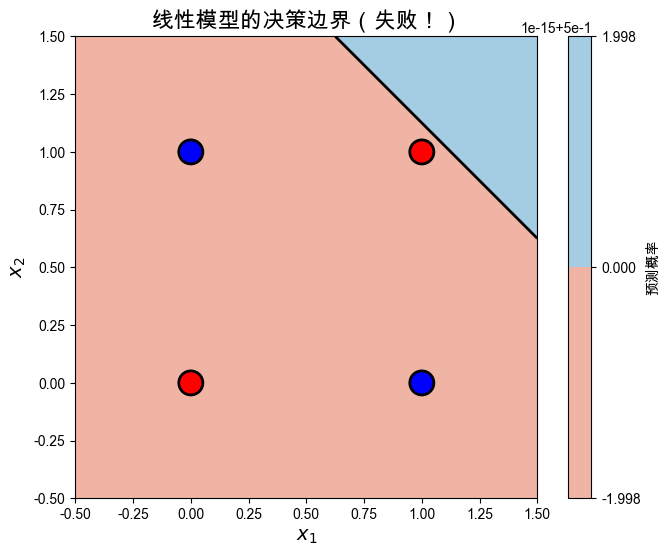

In [6]:
def plot_decision_boundary_linear(X, y, w, b, title):
    """绘制线性模型的决策边界"""
    plt.figure(figsize=(8, 6))
    
    # 创建网格
    xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200), np.linspace(-0.5, 1.5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # 预测
    z = grid @ w + b
    probs = sigmoid(z).reshape(xx.shape)
    
    # 绘制概率热力图
    plt.contourf(xx, yy, probs, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label='预测概率')
    
    # 绘制决策边界 (概率=0.5的线)
    plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2)
    
    # 绘制数据点
    colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=300, edgecolors='black', linewidth=2, zorder=5)
    
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().set_aspect('equal')
    plt.show()

plot_decision_boundary_linear(X, y, w_linear, b_linear, '线性模型的决策边界（失败！）')

### 💡 关键洞察

**不是你的代码错了，是数学上不可能！**

线性模型的决策边界永远是一条**直线**（更高维是超平面）。

而 XOR 数据需要的是一个**非线性的边界**来分开对角线上的点。

这就是为什么单层感知机在 1969 年被 Minsky 和 Papert "杀死"的原因。

---
## 预备知识：ReLU 激活函数是什么？

在介绍两层 MLP 之前，我们需要了解另一个重要的激活函数：**ReLU**。

### 为什么需要 ReLU？

刚才我们看到，使用 Sigmoid 的线性模型无法解决 XOR 问题。这是因为：

> **线性变换 + 线性变换 = 还是线性变换**

即使我们堆叠很多层线性变换，结果仍然是线性的！

要打破这个限制，我们需要在层与层之间加入**非线性**变换。ReLU 就是最常用的一种！

### ReLU 函数的定义

ReLU（Rectified Linear Unit，整流线性单元）的公式非常简单：

$$\text{ReLU}(z) = \max(0, z)$$

用人话说就是：
- 如果输入 z 是正数，就原样输出
- 如果输入 z 是负数或零，就输出 0

### ReLU 的特点

| 输入 z | 输出 ReLU(z) | 说明 |
|--------|-------------|------|
| 5 | 5 | 正数保持不变 |
| 0.1 | 0.1 | 小正数也保持不变 |
| 0 | 0 | 零还是零 |
| -3 | 0 | 负数变成零 |
| -100 | 0 | 再大的负数也变成零 |

### 为什么选择 ReLU 而不是 Sigmoid？

| 对比项 | ReLU | Sigmoid |
|--------|------|---------|
| 计算速度 | 非常快（只需比较大小） | 较慢（需要指数运算） |
| 梯度问题 | 正区间梯度恒为1 | 两端梯度接近0（梯度消失） |
| 稀疏性 | 负数变0，产生稀疏表示 | 输出都是非零值 |
| 应用场景 | 隐藏层首选 | 输出层二分类 |

### 直观理解

ReLU 就像一个**门**：
- 正数信号可以通过（开门）
- 负数信号被阻挡（关门）

这个简单的操作，就足以让神经网络学会非线性的模式！

### 在我们的 MLP 中

我们的网络结构是：

- **ReLU** 用在隐藏层：让网络能学习非线性模式
- **Sigmoid** 用在输出层：把结果转换成 0-1 的概率

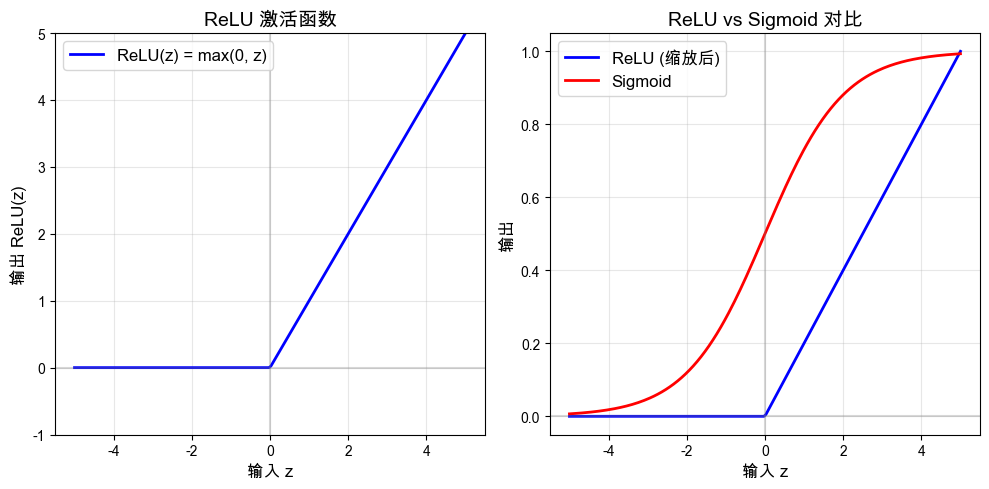

ReLU 的关键特点：
1. 公式超简单：max(0, z)
2. 计算超快：只需要一次比较操作
3. 正区间梯度恒为 1，不会梯度消失
4. 负区间输出 0，产生稀疏激活


In [7]:
# 可视化 ReLU 函数
z = np.linspace(-5, 5, 200)
relu_values = np.maximum(0, z)

plt.figure(figsize=(10, 5))

# 左图：ReLU 曲线
plt.subplot(1, 2, 1)
plt.plot(z, relu_values, "b-", linewidth=2, label="ReLU(z) = max(0, z)")
plt.axhline(y=0, color="gray", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="gray", linestyle="-", alpha=0.3)
plt.xlabel("输入 z", fontsize=12)
plt.ylabel("输出 ReLU(z)", fontsize=12)
plt.title("ReLU 激活函数", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(-1, 5)

# 右图：ReLU vs Sigmoid 对比
plt.subplot(1, 2, 2)
sigmoid_values = 1 / (1 + np.exp(-z))
plt.plot(z, relu_values / 5, "b-", linewidth=2, label="ReLU (缩放后)")  # 缩放以便对比
plt.plot(z, sigmoid_values, "r-", linewidth=2, label="Sigmoid")
plt.axhline(y=0, color="gray", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="gray", linestyle="-", alpha=0.3)
plt.xlabel("输入 z", fontsize=12)
plt.ylabel("输出", fontsize=12)
plt.title("ReLU vs Sigmoid 对比", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ReLU 的关键特点：")
print("1. 公式超简单：max(0, z)")
print("2. 计算超快：只需要一次比较操作")
print("3. 正区间梯度恒为 1，不会梯度消失")
print("4. 负区间输出 0，产生稀疏激活")

---
## 4. Step 2：两层 MLP 的结构

现在我们加入一个**隐藏层**和**非线性激活函数 ReLU**。

### 网络结构

```
Input (2)
  ↓
Linear (W1: 2×4, b1)
  ↓
ReLU
  ↓
Linear (W2: 4×1, b2)
  ↓
Sigmoid
  ↓
Output (1)
```

### 为什么是「两层」MLP？

- 2 个 Linear 层
- 中间 1 个非线性（ReLU）
- 这是能解决 XOR 的**最小结构**

### 为什么隐藏层是 4 个神经元？

- 2 个：有时不够稳定
- 4 个：训练更稳定，boundary 更清晰
- 更多：教学价值不增加，徒增复杂度

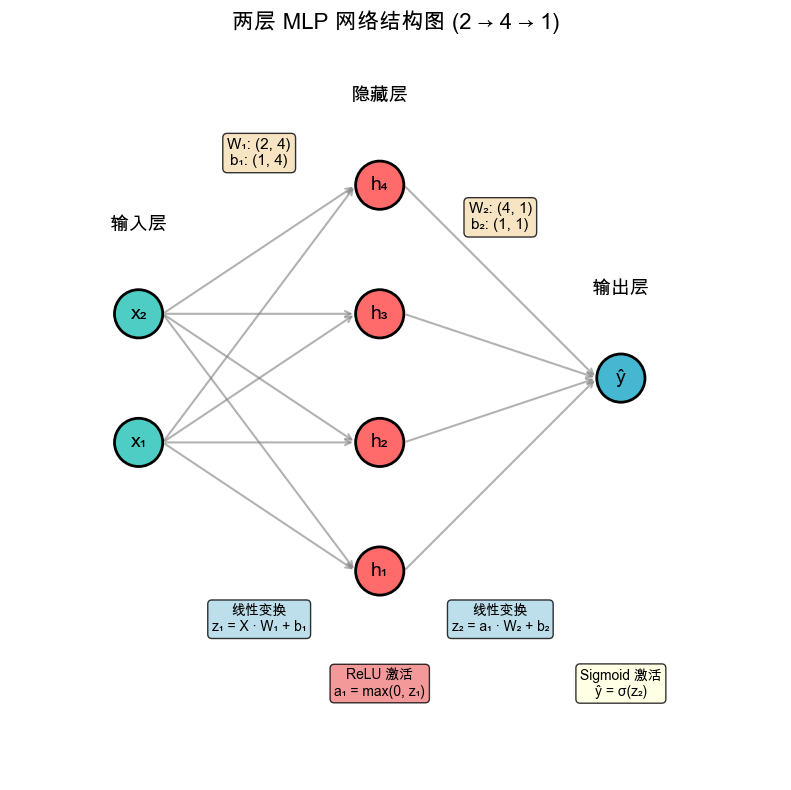

网络结构说明：
• 输入层：2 个神经元（对应 x₁ 和 x₂）
• 隐藏层：4 个神经元（使用 ReLU 激活函数）
• 输出层：1 个神经元（使用 Sigmoid 激活函数，输出概率）

每条连接线都有一个权重，这就是模型需要学习的参数！


In [8]:
# 可视化 MLP 网络结构
def draw_mlp_architecture():
    """绘制 2->4->1 的 MLP 网络结构图"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 定义每层的位置和神经元数量
    layers = {
        "输入层": {"x": 0, "neurons": 2, "labels": ["x₁", "x₂"]},
        "隐藏层": {"x": 1.5, "neurons": 4, "labels": ["h₁", "h₂", "h₃", "h₄"]},
        "输出层": {"x": 3, "neurons": 1, "labels": ["ŷ"]}
    }
    
    neuron_radius = 0.15
    colors = {"输入层": "#4ECDC4", "隐藏层": "#FF6B6B", "输出层": "#45B7D1"}
    
    # 存储神经元位置
    positions = {}
    
    # 绘制每层的神经元
    for layer_name, layer_info in layers.items():
        x = layer_info["x"]
        n = layer_info["neurons"]
        labels = layer_info["labels"]
        
        # 计算y坐标，使神经元垂直居中
        y_positions = np.linspace(-(n-1)/2 * 0.8, (n-1)/2 * 0.8, n)
        positions[layer_name] = [(x, y) for y in y_positions]
        
        for idx, (y, label) in enumerate(zip(y_positions, labels)):
            circle = plt.Circle((x, y), neuron_radius, color=colors[layer_name], 
                               ec="black", linewidth=2, zorder=10)
            ax.add_patch(circle)
            ax.text(x, y, label, ha="center", va="center", fontsize=14, 
                   fontweight="bold", zorder=11)
        
        # 层标签
        ax.text(x, max(y_positions) + 0.5, layer_name, ha="center", va="bottom", 
               fontsize=14, fontweight="bold")
    
    # 绘制连接线（从输入层到隐藏层）
    for (x1, y1) in positions["输入层"]:
        for (x2, y2) in positions["隐藏层"]:
            ax.annotate("", xy=(x2-neuron_radius, y2), xytext=(x1+neuron_radius, y1),
                       arrowprops=dict(arrowstyle="->", color="gray", lw=1.5, alpha=0.6))
    
    # 绘制连接线（从隐藏层到输出层）
    for (x1, y1) in positions["隐藏层"]:
        for (x2, y2) in positions["输出层"]:
            ax.annotate("", xy=(x2-neuron_radius, y2), xytext=(x1+neuron_radius, y1),
                       arrowprops=dict(arrowstyle="->", color="gray", lw=1.5, alpha=0.6))
    
    # 添加权重标签（使用普通文本）
    ax.text(0.75, 1.4, "W₁: (2, 4)\nb₁: (1, 4)", ha="center", va="center", 
           fontsize=11, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
    ax.text(2.25, 1.0, "W₂: (4, 1)\nb₂: (1, 1)", ha="center", va="center", 
           fontsize=11, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
    
    # 添加激活函数标签（使用普通文本）
    ax.text(0.75, -1.5, "线性变换\nz₁ = X · W₁ + b₁", ha="center", va="center", 
           fontsize=10, bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))
    ax.text(1.5, -1.9, "ReLU 激活\na₁ = max(0, z₁)", ha="center", va="center", 
           fontsize=10, bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.8))
    ax.text(2.25, -1.5, "线性变换\nz₂ = a₁ · W₂ + b₂", ha="center", va="center", 
           fontsize=10, bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))
    ax.text(3.0, -1.9, "Sigmoid 激活\nŷ = σ(z₂)", ha="center", va="center", 
           fontsize=10, bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8))
    
    ax.set_xlim(-0.8, 4)
    ax.set_ylim(-2.5, 2)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title("两层 MLP 网络结构图 (2 → 4 → 1)", fontsize=16, fontweight="bold", pad=20)
    
    plt.tight_layout()
    plt.show()

draw_mlp_architecture()

print("网络结构说明：")
print("• 输入层：2 个神经元（对应 x₁ 和 x₂）")
print("• 隐藏层：4 个神经元（使用 ReLU 激活函数）")
print("• 输出层：1 个神经元（使用 Sigmoid 激活函数，输出概率）")
print("\n每条连接线都有一个权重，这就是模型需要学习的参数！")

In [9]:
def relu(z):
    """ReLU 激活函数"""
    return np.maximum(0, z)

def relu_derivative(z):
    """ReLU 的导数"""
    return (z > 0).astype(float)

---
## 5. Step 3：逐行讲解 Forward Pass

### 前向传播公式

$$z_1 = X \cdot W_1 + b_1$$
$$a_1 = \text{ReLU}(z_1)$$
$$z_2 = a_1 \cdot W_2 + b_2$$
$$\hat{y} = \sigma(z_2)$$

### Shape 分析

| 变量 | Shape | 含义 |
|------|-------|------|
| X | (4, 2) | 4个样本，2个特征 |
| W1 | (2, 4) | 输入2维 → 隐藏4维 |
| b1 | (1, 4) | 隐藏层偏置 |
| z1 | (4, 4) | 隐藏层线性输出 |
| a1 | (4, 4) | 隐藏层激活输出 |
| W2 | (4, 1) | 隐藏4维 → 输出1维 |
| b2 | (1, 1) | 输出层偏置 |
| z2 | (4, 1) | 输出层线性输出 |
| y_hat | (4, 1) | 最终预测概率 |

In [10]:
def forward(X, W1, b1, W2, b2):
    """
    两层 MLP 的前向传播
    
    逐行解释：
    1. z1 = X @ W1 + b1  : 第一层线性变换
    2. a1 = relu(z1)     : ReLU 非线性激活
    3. z2 = a1 @ W2 + b2 : 第二层线性变换
    4. y_hat = sigmoid(z2): Sigmoid 输出概率
    """
    # 第一层：线性变换
    z1 = X @ W1 + b1
    
    # 第一层：ReLU 激活
    a1 = relu(z1)
    
    # 第二层：线性变换
    z2 = a1 @ W2 + b2
    
    # 输出层：Sigmoid
    y_hat = sigmoid(z2)
    
    # 保存中间变量，用于反向传播
    cache = {'z1': z1, 'a1': a1, 'z2': z2, 'y_hat': y_hat}
    
    return y_hat, cache

In [11]:
# 初始化参数
np.random.seed(42)

# He 初始化（适合 ReLU）
W1 = np.random.randn(2, 4) * np.sqrt(2.0 / 2)
b1 = np.zeros((1, 4))
W2 = np.random.randn(4, 1) * np.sqrt(2.0 / 4)
b2 = np.zeros((1, 1))

print("初始化参数 Shape:")
print(f"W1: {W1.shape}, b1: {b1.shape}")
print(f"W2: {W2.shape}, b2: {b2.shape}")

# 验证前向传播
y_hat, cache = forward(X, W1, b1, W2, b2)

print("\n中间变量 Shape:")
for name, value in cache.items():
    print(f"{name}: {value.shape}")

初始化参数 Shape:
W1: (2, 4), b1: (1, 4)
W2: (4, 1), b2: (1, 1)

中间变量 Shape:
z1: (4, 4)
a1: (4, 4)
z2: (4, 1)
y_hat: (4, 1)


---
## 6. Step 4：逐行讲解 Backward Pass（核心！）

这是整节课的**灵魂**。我们要用**链式法则**，一层层把梯度传回去。

### 损失函数

$$L = -\frac{1}{N}\sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i) \right]$$

### 反向传播公式推导

**Step 1: 输出层梯度**

$$\frac{\partial L}{\partial z_2} = \hat{y} - y$$

这个结果非常优雅！Sigmoid + BCE 的组合让梯度简化为预测值与真实值的差。

**Step 2: 第二层参数梯度**

$$\frac{\partial L}{\partial W_2} = a_1^T \cdot \frac{\partial L}{\partial z_2}$$

$$\frac{\partial L}{\partial b_2} = \sum \frac{\partial L}{\partial z_2}$$

**Step 3: 隐藏层激活梯度**

$$\frac{\partial L}{\partial a_1} = \frac{\partial L}{\partial z_2} \cdot W_2^T$$

**Step 4: 隐藏层线性梯度**

$$\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial a_1} \odot \text{ReLU}'(z_1)$$

其中 $\odot$ 表示逐元素乘法，$\text{ReLU}'(z) = \mathbb{1}_{z > 0}$

**Step 5: 第一层参数梯度**

$$\frac{\partial L}{\partial W_1} = X^T \cdot \frac{\partial L}{\partial z_1}$$

$$\frac{\partial L}{\partial b_1} = \sum \frac{\partial L}{\partial z_1}$$

In [12]:
def backward(X, y, cache, W2):
    """
    两层 MLP 的反向传播
    
    这是整节课的灵魂！
    请仔细理解每一行代码对应的数学公式。
    """
    m = X.shape[0]  # 样本数量
    
    # 取出缓存的中间变量
    z1 = cache['z1']
    a1 = cache['a1']
    y_hat = cache['y_hat']
    
    # === 输出层 ===
    # dL/dz2 = y_hat - y  (Sigmoid + BCE 的优美性质)
    dz2 = y_hat - y
    
    # === 第二层参数梯度 ===
    # dL/dW2 = a1.T @ dz2
    dW2 = a1.T @ dz2 / m
    
    # dL/db2 = sum(dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True) / m
    
    # === 反向传到隐藏层 ===
    # dL/da1 = dz2 @ W2.T
    da1 = dz2 @ W2.T
    
    # dL/dz1 = da1 * relu_grad(z1)
    dz1 = da1 * relu_derivative(z1)
    
    # === 第一层参数梯度 ===
    # dL/dW1 = X.T @ dz1
    dW1 = X.T @ dz1 / m
    
    # dL/db1 = sum(dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True) / m
    
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    return grads

---
## 7. 训练两层 MLP

In [13]:
# 重新初始化参数
np.random.seed(42)
W1 = np.random.randn(2, 4) * np.sqrt(2.0 / 2)
b1 = np.zeros((1, 4))
W2 = np.random.randn(4, 1) * np.sqrt(2.0 / 4)
b2 = np.zeros((1, 1))

# 超参数
learning_rate = 1.0
num_epochs = 1000

# 记录训练历史
losses_mlp = []

print("训练两层 MLP...")
print("=" * 60)

for epoch in range(num_epochs):
    # 前向传播
    y_hat, cache = forward(X, W1, b1, W2, b2)
    
    # 计算损失
    loss = binary_cross_entropy(y, y_hat)
    losses_mlp.append(loss)
    
    # 反向传播
    grads = backward(X, y, cache, W2)
    
    # 梯度下降更新参数
    W1 = W1 - learning_rate * grads['dW1']
    b1 = b1 - learning_rate * grads['db1']
    W2 = W2 - learning_rate * grads['dW2']
    b2 = b2 - learning_rate * grads['db2']
    
    if epoch % 200 == 0:
        predictions = (y_hat > 0.5).astype(int)
        accuracy = np.mean(predictions == y)
        print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Accuracy: {accuracy:.0%}")

print("=" * 60)
print(f"\n最终 Loss: {losses_mlp[-1]:.6f}")
print(f"最终预测: {y_hat.flatten().round(3)}")
print(f"预测分类: {(y_hat > 0.5).astype(int).flatten()}")
print(f"真实标签: {y.flatten()}")

训练两层 MLP...
Epoch    0 | Loss: 0.8147 | Accuracy: 50%
Epoch  200 | Loss: 0.0196 | Accuracy: 100%
Epoch  400 | Loss: 0.0067 | Accuracy: 100%
Epoch  600 | Loss: 0.0039 | Accuracy: 100%
Epoch  800 | Loss: 0.0027 | Accuracy: 100%

最终 Loss: 0.002098
最终预测: [0.006 0.999 0.999 0.001]
预测分类: [0 1 1 0]
真实标签: [0 1 1 0]


---
## 8. 可视化对比

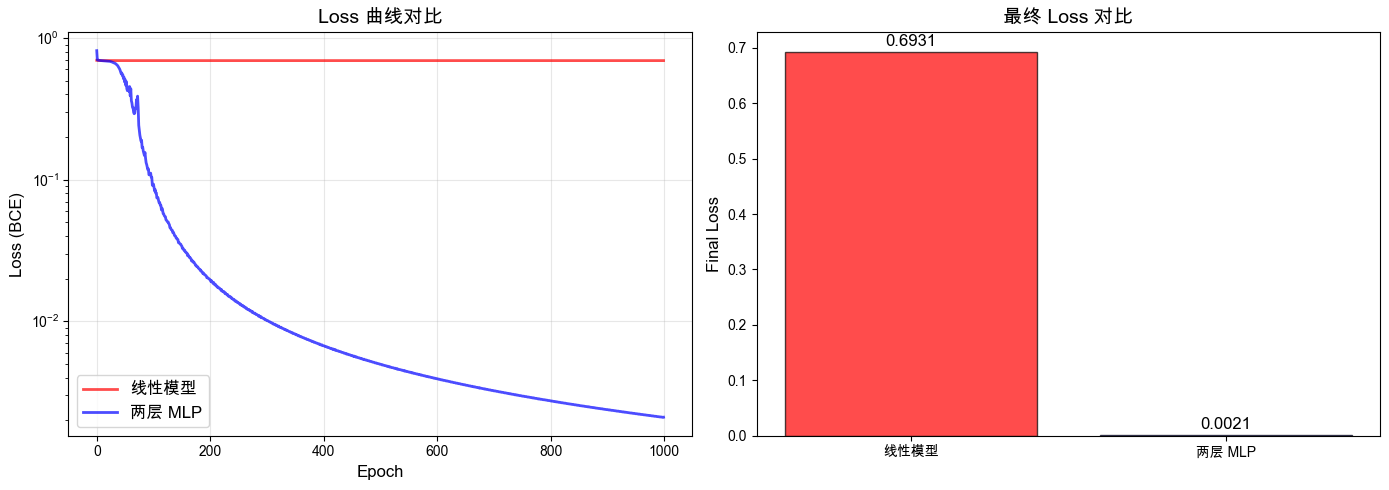

In [14]:
# 对比 Loss 曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：Loss 对比
axes[0].plot(losses_linear, 'r-', linewidth=2, label='线性模型', alpha=0.7)
axes[0].plot(losses_mlp, 'b-', linewidth=2, label='两层 MLP', alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (BCE)', fontsize=12)
axes[0].set_title('Loss 曲线对比', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# 右图：最终 Loss 对比
models = ['线性模型', '两层 MLP']
final_losses = [losses_linear[-1], losses_mlp[-1]]
colors = ['red', 'blue']
bars = axes[1].bar(models, final_losses, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Final Loss', fontsize=12)
axes[1].set_title('最终 Loss 对比', fontsize=14)
for bar, loss in zip(bars, final_losses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{loss:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

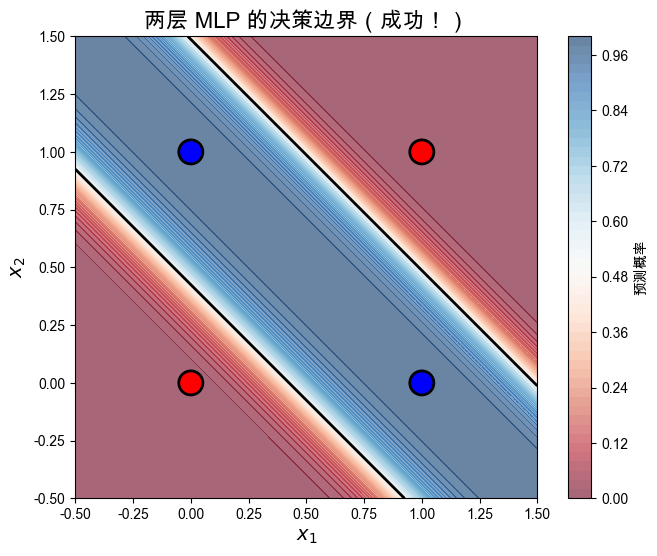

In [15]:
def plot_decision_boundary_mlp(X, y, W1, b1, W2, b2, title):
    """绘制 MLP 的决策边界"""
    plt.figure(figsize=(8, 6))
    
    # 创建网格
    xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200), np.linspace(-0.5, 1.5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # 前向传播
    z1 = grid @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    probs = sigmoid(z2).reshape(xx.shape)
    
    # 绘制概率热力图
    plt.contourf(xx, yy, probs, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label='预测概率')
    
    # 绘制决策边界
    plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2)
    
    # 绘制数据点
    colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=300, edgecolors='black', linewidth=2, zorder=5)
    
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().set_aspect('equal')
    plt.show()

plot_decision_boundary_mlp(X, y, W1, b1, W2, b2, '两层 MLP 的决策边界（成功！）')

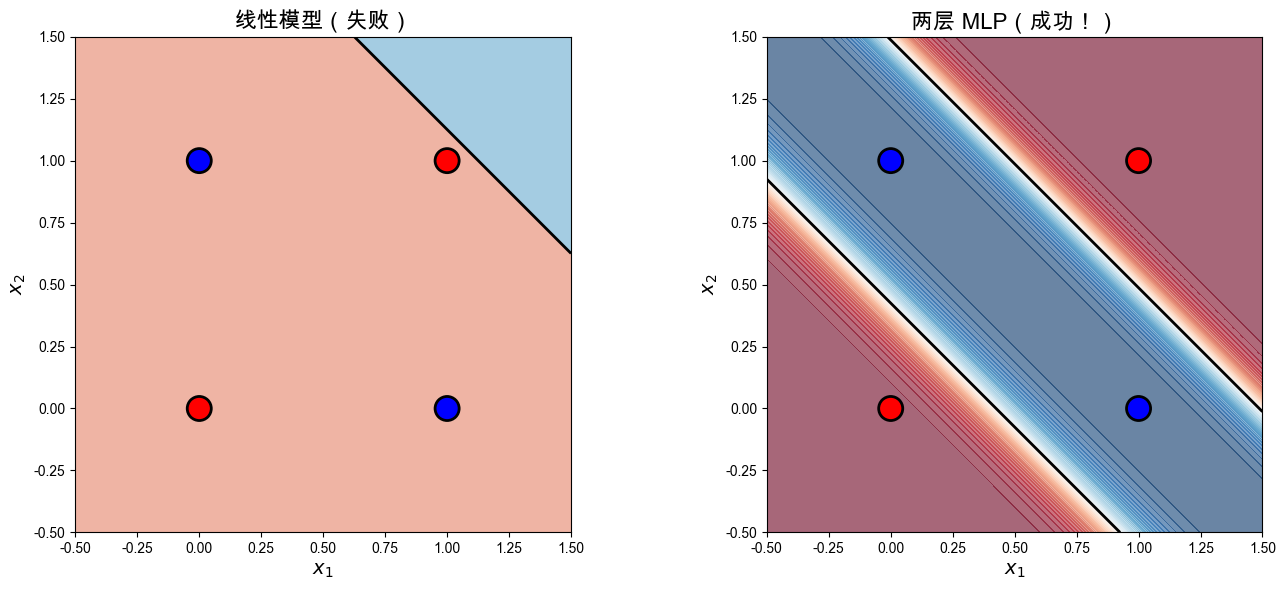


观察：
- 左图：线性模型的决策边界是一条直线，无法分开对角的点
- 右图：MLP的决策边界是分段线性的（折线），成功把红蓝分开！


In [16]:
# 并排对比
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 创建网格
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200), np.linspace(-0.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

# 左图：线性模型
ax = axes[0]
z = grid @ w_linear + b_linear
probs_linear = sigmoid(z).reshape(xx.shape)
ax.contourf(xx, yy, probs_linear, levels=50, cmap='RdBu', alpha=0.6)
ax.contour(xx, yy, probs_linear, levels=[0.5], colors='black', linewidths=2)
colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
ax.scatter(X[:, 0], X[:, 1], c=colors, s=300, edgecolors='black', linewidth=2, zorder=5)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_title('线性模型（失败）', fontsize=16)
ax.set_aspect('equal')

# 右图：两层 MLP
ax = axes[1]
z1 = grid @ W1 + b1
a1 = relu(z1)
z2 = a1 @ W2 + b2
probs_mlp = sigmoid(z2).reshape(xx.shape)
ax.contourf(xx, yy, probs_mlp, levels=50, cmap='RdBu', alpha=0.6)
ax.contour(xx, yy, probs_mlp, levels=[0.5], colors='black', linewidths=2)
ax.scatter(X[:, 0], X[:, 1], c=colors, s=300, edgecolors='black', linewidth=2, zorder=5)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_title('两层 MLP（成功！）', fontsize=16)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n观察：")
print("- 左图：线性模型的决策边界是一条直线，无法分开对角的点")
print("- 右图：MLP的决策边界是分段线性的（折线），成功把红蓝分开！")

### 📢 重要提醒：关于决策边界的准确理解

观察上图，你可能注意到 MLP 的决策边界看起来像是**两条直线拼接**，而不是一条光滑的曲线。

**这不是 bug，而是数学上的必然结果！**

#### 为什么 ReLU 决定了只能是折线？

ReLU 激活函数的定义是：

$$\text{ReLU}(z) = \max(0, z)$$

它有一个关键性质：**在每一个区间上都是线性的**。

- 当 $w^T x + b > 0$ 时：$\text{ReLU}(z) = z$（线性）
- 当 $w^T x + b \leq 0$ 时：$\text{ReLU}(z) = 0$（常数）

👉 **每个 ReLU 神经元都会把输入空间切成两个半空间**。

#### 多个 ReLU 叠加会发生什么？

当多个 ReLU 神经元叠加时：

1. 输入空间被切成很多个**多边形区域**
2. 在每一个区域内，整个网络都是：$f(x) = Ax + c$（线性函数）
3. 但**不同区域**用的是**不同的线性函数**

所以最终结果是：

> **全局看起来非线性，但局部永远是线性的。**

这就解释了为什么我们看到的决策边界是**分段线性的折线边界**，而不是光滑的曲线。

这是一个重要的数学洞察：**ReLU 网络是分段线性函数**。

---
## 9. 隐藏层在做什么？——几何视角

ReLU 在几何上做了什么？让我们可视化隐藏层的输出。

In [17]:
# 计算隐藏层输出
z1_data = X @ W1 + b1
a1_data = relu(z1_data)

print("原始输入 X:")
print(X)
print("\n隐藏层输出 a1 (ReLU 之后):")
print(a1_data.round(3))

原始输入 X:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

隐藏层输出 a1 (ReLU 之后):
[[0.    0.    0.    0.   ]
 [0.    0.    0.    3.055]
 [0.    0.    0.    3.055]
 [0.762 0.    3.988 6.113]]


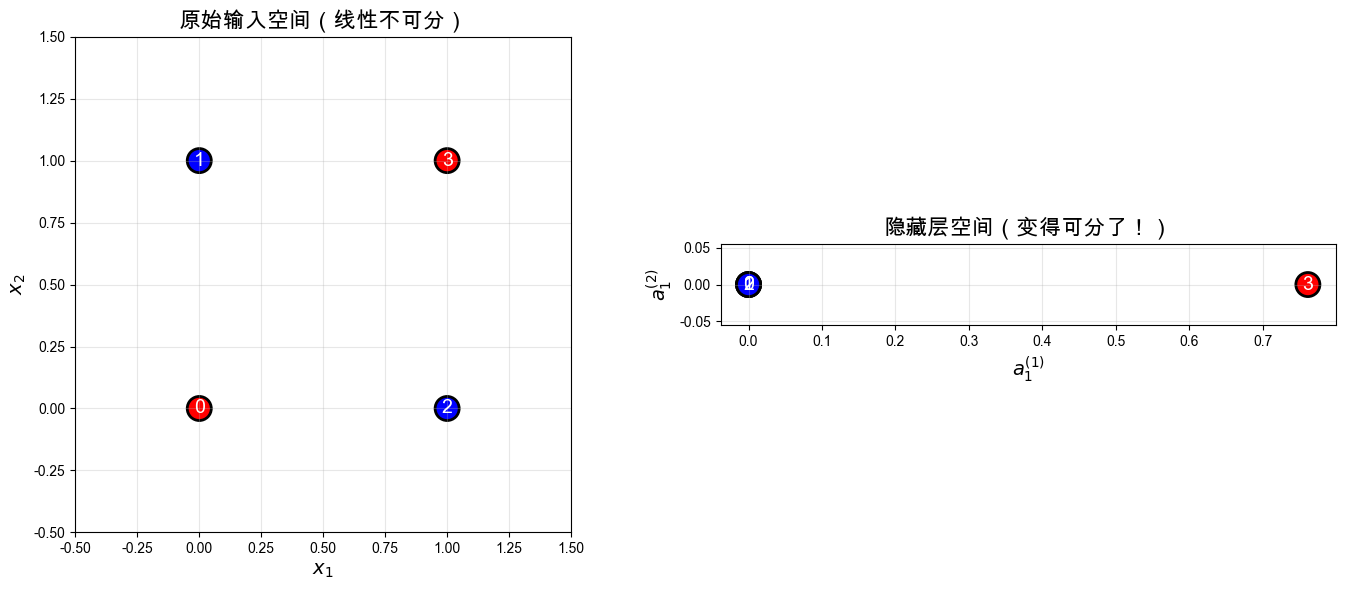


关键洞察：
隐藏层把原本'纠缠'在一起的点，'拉开'到了新的空间
在新空间里，红蓝点变得线性可分了！


In [18]:
# 可视化隐藏层的前两个维度
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左图：原始空间
ax = axes[0]
colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
ax.scatter(X[:, 0], X[:, 1], c=colors, s=300, edgecolors='black', linewidth=2)
for i, (x1, x2) in enumerate(X):
    ax.annotate(f'{i}', (x1, x2), fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_title('原始输入空间（线性不可分）', fontsize=16)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# 右图：隐藏层空间（取前2个维度）
ax = axes[1]
ax.scatter(a1_data[:, 0], a1_data[:, 1], c=colors, s=300, edgecolors='black', linewidth=2)
for i, (h1, h2) in enumerate(a1_data[:, :2]):
    ax.annotate(f'{i}', (h1, h2), fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax.set_xlabel('$a_1^{(1)}$', fontsize=14)
ax.set_ylabel('$a_1^{(2)}$', fontsize=14)
ax.set_title('隐藏层空间（变得可分了！）', fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n关键洞察：")
print("隐藏层把原本'纠缠'在一起的点，'拉开'到了新的空间")
print("在新空间里，红蓝点变得线性可分了！")

---
## 10. 课堂检查点：5 个核心问题

如果你能回答 3 个以上，这节课就成功了！

### 问题 1：如果去掉 ReLU，会发生什么？

In [19]:
# 实验：去掉 ReLU
np.random.seed(42)
W1_no_relu = np.random.randn(2, 4) * np.sqrt(2.0 / 2)
b1_no_relu = np.zeros((1, 4))
W2_no_relu = np.random.randn(4, 1) * np.sqrt(2.0 / 4)
b2_no_relu = np.zeros((1, 1))

losses_no_relu = []

for epoch in range(1000):
    # 前向传播（没有 ReLU！）
    z1 = X @ W1_no_relu + b1_no_relu
    a1 = z1  # 直接用 z1，没有激活！
    z2 = a1 @ W2_no_relu + b2_no_relu
    y_hat = sigmoid(z2)
    
    loss = binary_cross_entropy(y, y_hat)
    losses_no_relu.append(loss)
    
    # 反向传播
    dz2 = y_hat - y
    dW2 = a1.T @ dz2 / 4
    db2 = np.sum(dz2, axis=0, keepdims=True) / 4
    da1 = dz2 @ W2_no_relu.T
    dz1 = da1  # 没有 ReLU 导数
    dW1 = X.T @ dz1 / 4
    db1 = np.sum(dz1, axis=0, keepdims=True) / 4
    
    W1_no_relu -= 1.0 * dW1
    b1_no_relu -= 1.0 * db1
    W2_no_relu -= 1.0 * dW2
    b2_no_relu -= 1.0 * db2

print(f"去掉 ReLU 后的最终 Loss: {losses_no_relu[-1]:.4f}")
print(f"有 ReLU 的最终 Loss: {losses_mlp[-1]:.4f}")
print("\n结论：去掉 ReLU 后，模型退化成线性模型，无法学会 XOR！")

去掉 ReLU 后的最终 Loss: 0.6931
有 ReLU 的最终 Loss: 0.0021

结论：去掉 ReLU 后，模型退化成线性模型，无法学会 XOR！


### 问题 2：为什么一层线性永远学不会 XOR？

**答案**：

线性模型的决策边界是：$w_1 x_1 + w_2 x_2 + b = 0$

这是一条**直线**。

而 XOR 的四个点，需要用**非线性的边界**才能分开。

这不是调参能解决的，是**数学上的不可能**。

---

### 问题 3：ReLU 在几何上做了什么？

**答案**：

ReLU 做了一个**折叠**操作：
- 对于 $z > 0$ 的部分，保持不变
- 对于 $z \leq 0$ 的部分，压成 0

这个"折叠"把原本线性不可分的数据，变换到一个新的空间，使其变得线性可分。

---

### 问题 4：梯度为什么能一层层传？

**答案**：

因为**链式法则**！

$$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial z_2} \cdot \frac{\partial z_2}{\partial a_1} \cdot \frac{\partial a_1}{\partial z_1} \cdot \frac{\partial z_1}{\partial W_1}$$

每一层的梯度，都可以通过乘上"上一层传下来的梯度"来计算。

这就是**反向传播 (Backpropagation)** 的本质。

---

### 问题 5：W1 和 W2 各自学到的是什么？

**答案**：

- **W1**：学习如何把原始空间"变形"，让数据变得可分
- **W2**：在变形后的空间里，画一条分界面

In [20]:
print("学习到的 W1:")
print(W1.round(3))
print("\n学习到的 W2:")
print(W2.round(3))
print("\nW1 的每一列代表一个隐藏神经元如何'看'输入")
print("W2 的每一行代表输出如何组合隐藏层的信息")

学习到的 W1:
[[ 0.762 -0.138  3.988  3.058]
 [ 0.762 -0.234  3.988  3.058]]

学习到的 W2:
[[-1.198]
 [ 0.384]
 [-6.396]
 [ 3.964]]

W1 的每一列代表一个隐藏神经元如何'看'输入
W2 的每一行代表输出如何组合隐藏层的信息


---
## 11. 总结

### 这节课你学到了什么？

1. **线性模型的局限**：单层线性模型无法解决 XOR（数学上不可能）

2. **非线性的力量**：加一层 ReLU，问题就解决了

3. **前向传播**：
   ```
   z1 = X @ W1 + b1
   a1 = relu(z1)
   z2 = a1 @ W2 + b2
   y_hat = sigmoid(z2)
   ```

4. **反向传播**：
   ```
   dz2 = y_hat - y
   dW2 = a1.T @ dz2
   db2 = sum(dz2)
   da1 = dz2 @ W2.T
   dz1 = da1 * relu_grad(z1)
   dW1 = X.T @ dz1
   db1 = sum(dz1)
   ```

5. **深度学习的本质**：
   > 线性变换 + 非线性激活 + 链式法则

### 你现在具备的能力

- ✅ 看懂任何 MLP 的 forward / backward
- ✅ 明白 backprop 不是"黑魔法"
- ✅ 理解为什么需要非线性激活函数
- ✅ 能手写一个完整的神经网络

---

恭喜！你已经真正理解了神经网络的核心原理。接下来可以挑战更复杂的网络结构了！